In [333]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [334]:
df = pd.read_csv(
    "results.csv",
    encoding="utf-16", 
    sep="\t"
)

In [335]:
print(df.columns.tolist())

['CASE', 'SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'STATUS', 'FINISHED', 'Q_VIEWER', 'LASTPAGE', 'MAXPAGE', 'MISSING', 'MISSREL', 'TIME_RSI', 'DE01', 'DE01_08', 'DE02', 'DE04', 'DE03', 'DA01_01', 'DA02_01', 'DA02_02', 'DA02_03', 'DA02_04', 'DA02_05', 'DA02_06', 'DA02_07', 'DA02_08', 'DA02_09', 'DA02_10', 'DA02_11', 'DA02_12', 'DA02_13', 'DA02_14', 'DA02_15', 'DA02_16', 'DA02_17', 'DA02_18', 'DA02_19', 'DA02_20', 'DA02', 'PI01_01', 'PI01_02', 'PI01_03', 'PI01_04', 'PI01_05', 'LF01_01', 'LF01_02', 'LF01_03', 'LF01_04', 'LF01_05', 'CC01_01', 'CC01_02', 'CC01_03', 'CC01_04', 'CC01_05', 'CC01_06', 'CC01_07', 'CC01_08', 'CC01_09', 'CC01_10', 'CC01_11', 'CC01_12', 'CC01_13', 'CC01_14', 'CC01_15', 'OP01', 'OP02', 'OP03_01', 'OP03_02', 'OP03_03', 'OP03_04', 'OP03_05', 'OP03_06', 'OP03_06a', 'OP03_07', 'OP03', 'OR01_01', 'AC01', 'TIME001', 'TIME002', 'TIME003', 'TIME004', 'TIME005', 'TIME006', 'TIME_SUM', 'MAILSENT', 'LASTDATA']


In [336]:
print(df.shape[0])
# Remove unfinished participations
df= df[df["FINISHED"].astype(str).str.strip() == "1"]
df.to_csv("results_clean.csv", index=False)
print(df.shape[0])

47
22


In [337]:
print(df.shape[1])
# Drop unneccessary columns
cols_to_drop = [
    "SERIAL", "REF", "QUESTNNR", "MODE", "STARTED", "STATUS", "FINISHED",
    "Q_VIEWER", "LASTPAGE", "MAXPAGE", "MISSING", "MISSREL",
    "TIME_RSI", "TIME001", "TIME002", "TIME003", "TIME004", "TIME005",
    "TIME006", "TIME_SUM", "MAILSENT", "LASTDATA"
]
df = df.drop(columns=cols_to_drop)
print(df.shape[1])
df.to_csv(
    "survey_clean_columns.csv",  
    index=False,         
    encoding="utf-8",    
    sep=","          
)


88
66



Task-level correct counts:
CC01_04_CORR    19
CC01_01_CORR    18
CC01_08_CORR    18
CC01_07_CORR    17
CC01_11_CORR    17
CC01_05_CORR    16
CC01_06_CORR    14
CC01_10_CORR    14
CC01_14_CORR    12
CC01_09_CORR    11
CC01_02_CORR     9
CC01_12_CORR     9
CC01_13_CORR     7
CC01_03_CORR     6
CC01_15_CORR     5
dtype: int64

Overall accuracy distribution:
count    20.000000
mean      9.600000
std       2.458069
min       4.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      14.000000
Name: snippet_score, dtype: float64


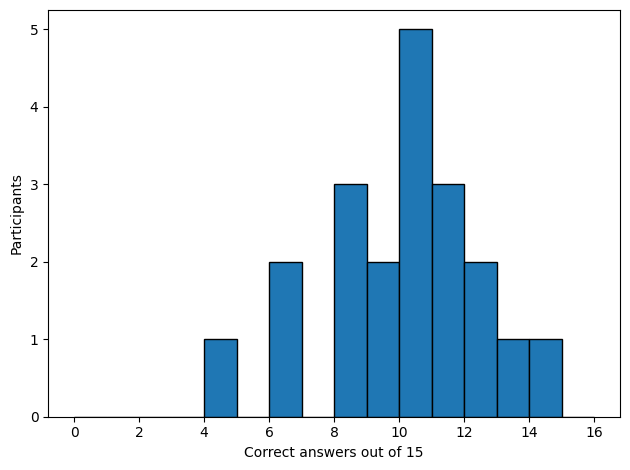

In [338]:
df = pd.read_csv("survey_clean_columns.csv", encoding="utf-8", sep=",")

answer_key = {
    "CC01_01": "Yes",   # e-mail
    "CC01_02": "Yes",   # IP
    "CC01_03": "No",    # UUID
    "CC01_04": "Yes",   # GPS lat/lon
    "CC01_05": "Yes",   # plain password
    "CC01_06": "No",    # metric (latency)
    "CC01_07": "Yes",   # health data
    "CC01_08": "No",    # status log
    "CC01_09": "Yes",   # face-print
    "CC01_10": "Yes",   # session cookie
    "CC01_11": "No",    # config constant
    "CC01_12": "No",    # file checksum
    "CC01_13": "Yes",   # SSN
    "CC01_14": "Yes",   # political opinion
    "CC01_15": "Yes",   # criminal-offence code
}

for col, correct in answer_key.items():
    df[f"{col}_CORR"] = (df[col].str.strip() == correct).astype(int)

corr_cols = [f"{c}_CORR" for c in answer_key]
df["snippet_score"] = df[corr_cols].sum(axis=1)

df = df[df["snippet_score"] > 0].copy() 
df.to_csv("survey_clean_columns_noZero.csv", index=False, encoding="utf-8")

print("\nTask-level correct counts:")
print(df[corr_cols].sum().sort_values(ascending=False))

print("\nOverall accuracy distribution:")
print(df["snippet_score"].describe())

plt.hist(df["snippet_score"], bins=range(0,17), edgecolor="black")
plt.xlabel("Correct answers out of 15")
plt.ylabel("Participants")
plt.tight_layout()
plt.show()

/var/folders/gm/qkw22hmj6nb1q482lc1rgxqc0000gn/T/ipykernel_39506/1006873133.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["1-3 yrs","4-7 yrs"], patch_artist=False)


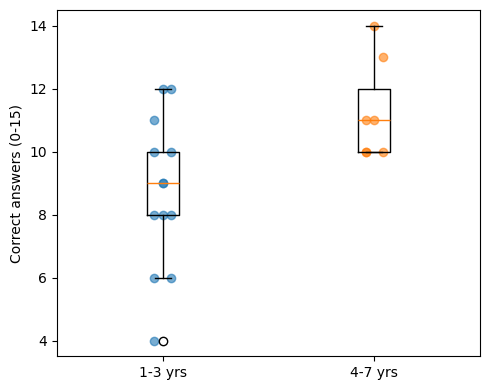

Overall: 9.60 ± 2.46
1-3 yrs: 8.69 ± 2.39
4-7 yrs: 11.29 ± 1.60


In [339]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
exp_map = {
    "1-3 years": "1-3 yrs",
    "4-7 years": "4-7 yrs",
}
df["exp_band_2"] = df["DE02"].map(exp_map)

plt.figure(figsize=(5,4))

# boxplot
data = [df.loc[df["exp_band_2"] == b, "snippet_score"]
        for b in ["1-3 yrs","4-7 yrs"]]
plt.boxplot(data, labels=["1-3 yrs","4-7 yrs"], patch_artist=False)

# individual dots (jitter)
for i, band in enumerate(["1-3 yrs","4-7 yrs"], start=1):
    y = df.loc[df["exp_band_2"] == band, "snippet_score"]
    x = [i + 0.04*((j % 3) - 1) for j in range(len(y))]  # simple jitter
    plt.scatter(x, y, alpha=0.6)

plt.ylabel("Correct answers (0-15)")
plt.tight_layout()
plt.show()

def mean_sd(series):
    return f"{series.mean():.2f} ± {series.std(ddof=1):.2f}"

print("Overall:", mean_sd(df["snippet_score"]))

# per-group examples
print("1-3 yrs:", mean_sd(df.loc[df["exp_band_2"]=="1-3 yrs","snippet_score"]))
print("4-7 yrs:", mean_sd(df.loc[df["exp_band_2"]=="4-7 yrs","snippet_score"]))


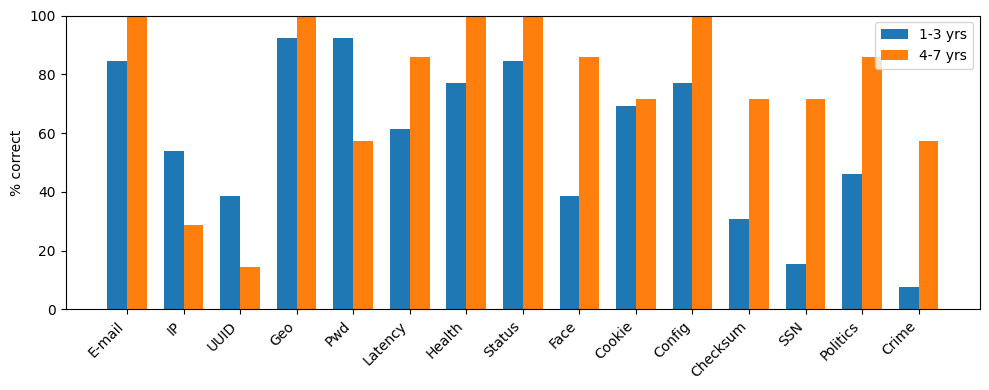


Overall accuracy (after filtering zero-scores):
count    20.000000
mean      9.600000
std       2.458069
min       4.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      14.000000
Name: snippet_score, dtype: float64

% correct per component by band:
band          1-3 yrs  4-7 yrs
CC01_01_CORR     84.6    100.0
CC01_02_CORR     53.8     28.6
CC01_03_CORR     38.5     14.3
CC01_04_CORR     92.3    100.0
CC01_05_CORR     92.3     57.1
CC01_06_CORR     61.5     85.7
CC01_07_CORR     76.9    100.0
CC01_08_CORR     84.6    100.0
CC01_09_CORR     38.5     85.7
CC01_10_CORR     69.2     71.4
CC01_11_CORR     76.9    100.0
CC01_12_CORR     30.8     71.4
CC01_13_CORR     15.4     71.4
CC01_14_CORR     46.2     85.7
CC01_15_CORR      7.7     57.1


In [340]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
EXPERIENCE_BANDS = {
    "1-3 years": "1-3 yrs",           
    "4-7 years": "4-7 yrs",
}
LABELS_READABLE = [                 
    "E-mail", "IP", "UUID", "Geo", "Pwd",
    "Latency", "Health", "Status", "Face", "Cookie",
    "Config", "Checksum", "SSN", "Politics", "Crime"
]
EXPERIENCE_COL = "DE02"    
df["band"] = df[EXPERIENCE_COL].map(EXPERIENCE_BANDS)

proportions = (
    df.groupby("band")[corr_cols]
      .mean()
      .loc[list(EXPERIENCE_BANDS.values())] * 100     
)
x = np.arange(len(LABELS_READABLE))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, proportions.iloc[0], width, label=list(EXPERIENCE_BANDS.values())[0])
plt.bar(x + width/2, proportions.iloc[1], width, label=list(EXPERIENCE_BANDS.values())[1])
plt.ylabel("% correct")
plt.xticks(x, LABELS_READABLE, rotation=45, ha="right")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

print("\nOverall accuracy (after filtering zero-scores):")
print(df["snippet_score"].describe())

print("\n% correct per component by band:")
print(proportions.T.round(1))

In [341]:
snippet_cols = [
    "CC01_01","CC01_02","CC01_03","CC01_04","CC01_05",
    "CC01_06","CC01_07","CC01_08","CC01_09","CC01_10",
    "CC01_11","CC01_12","CC01_13","CC01_14","CC01_15"
]

all_unsure = df[snippet_cols].apply(lambda row: (row == "Unsure").all(), axis=1)

n_unsure  = all_unsure.sum()
n_total   = len(df)
pct       = n_unsure / n_total * 100

print(f"Participants who chose 'Unsure' on all 15 items: {n_unsure} of {n_total} "
      f"({pct:.1f} %)")

Participants who chose 'Unsure' on all 15 items: 0 of 20 (0.0 %)


In [342]:
df["policy"]   = df["OP01"].str.strip().eq("Yes").astype(int)
df["training"] = df["OP02"].str.strip().eq("Yes").astype(int)

# build a label column for the 3 main cases
def label_row(row):
    if row["policy"] and row["training"]:
        return "Yes to BOTH"
    if row["policy"] or row["training"]:
        return "Yes to ONE"
    return "No to BOTH"

df["combo"] = df.apply(label_row, axis=1)

# count each category
counts = df["combo"].value_counts().reindex(
    ["Yes to BOTH", "Yes to ONE", "No to BOTH"], fill_value=0
)

print(counts.to_string())

combo
Yes to BOTH    10
Yes to ONE      7
No to BOTH      3


/var/folders/gm/qkw22hmj6nb1q482lc1rgxqc0000gn/T/ipykernel_39506/4286189076.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, patch_artist=False)


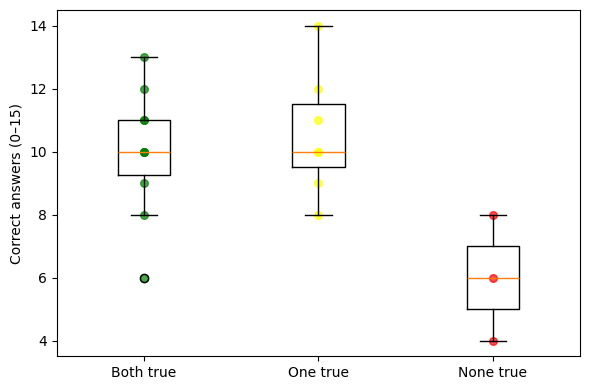

In [343]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
df["policy"]   = df["OP01"].str.strip().eq("Yes")
df["training"] = df["OP02"].str.strip().eq("Yes")
df["group"] = (
      df["policy"].map({True:1, False:0})
    + df["training"].map({True:1, False:0})
).map({2:"Both true", 1:"One true", 0:"None true"})


for col, correct in answer_key.items():
    df[f"{col}_CORR"] = (df[col].str.strip()==correct).astype(int)
df["snippet_score"] = df[[f"{c}_CORR" for c in answer_key]].sum(axis=1)


order   = ["Both true", "One true", "None true"]
colours = {"Both true":"green", "One true":"yellow", "None true":"red"}
data    = [df.loc[df["group"]==g, "snippet_score"] for g in order]


plt.figure(figsize=(6,4))
plt.boxplot(data, labels=order, patch_artist=False)

for idx, g in enumerate(order, start=1):
    y = df.loc[df["group"]==g, "snippet_score"]
    plt.scatter([idx]*len(y), y, color=colours[g], alpha=0.7, s=30)

plt.ylabel("Correct answers (0–15)")
plt.tight_layout()
plt.show()

In [344]:
one_true = df[(df["policy"] ^ df["training"])]

counts = {
    "Guidelines only" : len(one_true[ one_true["policy"]   & ~one_true["training"] ]),
    "Training only"   : len(one_true[~one_true["policy"]   &  one_true["training"] ])
}

print("Break-down of the 'Yes to ONE' group:")
for k, v in counts.items():
    print(f"  {k:15s} : {v}")

Break-down of the 'Yes to ONE' group:
  Guidelines only : 4
  Training only   : 3


Respondents by region:
DE04
EU / EEA           7
Central Asia       6
Eastern Europe     2
South East Asia    1
East Asia          1
North America      1
South Asia         1
Latin America      1


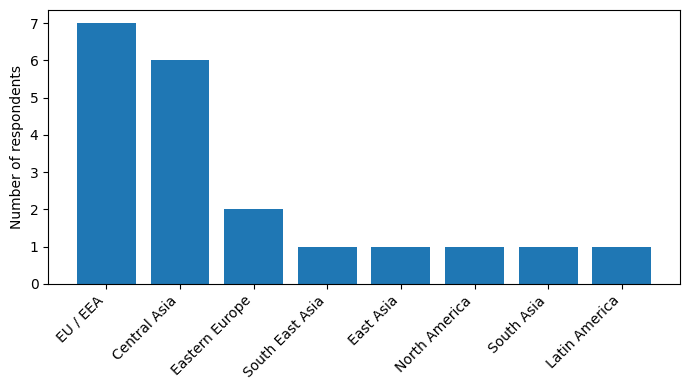

In [345]:
region_counts = (
    df["DE04"]
      .value_counts()
      .sort_values(ascending=False)
)


print("Respondents by region:")
print(region_counts.to_string())


plt.figure(figsize=(7,4))
plt.bar(region_counts.index.astype(str), region_counts.values)
plt.ylabel("Number of respondents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

EU / EEA     :  n= 7,  mean=9.14, sd=1.86
Central Asia :  n= 6,  mean=10.33, sd=2.25


/var/folders/gm/qkw22hmj6nb1q482lc1rgxqc0000gn/T/ipykernel_39506/356028610.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=False)


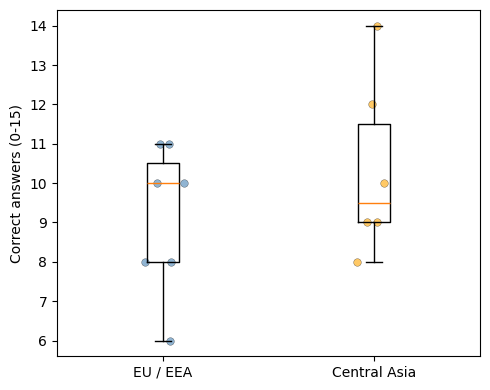

In [346]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
top2 = df["DE04"].value_counts().nlargest(2).index.tolist()
eu, ca = top2                  
df = df[df["DE04"].isin(top2)].copy()
df["region_clean"] = df["DE04"].replace({eu: "EU / EEA", ca: "Central Asia"})

for col, correct in answer_key.items():
    df[f"{col}_CORR"] = (df[col].str.strip()==correct).astype(int)
df["snippet_score"] = df[[f"{c}_CORR" for c in answer_key]].sum(axis=1)


for reg in ["EU / EEA", "Central Asia"]:
    scores = df.loc[df["region_clean"] == reg, "snippet_score"]
    print(f"{reg:13s}:  n={len(scores):2d},  mean={scores.mean():.2f}, sd={scores.std(ddof=1):.2f}")


labels  = ["EU / EEA", "Central Asia"]
data    = [df.loc[df["region_clean"] == lab, "snippet_score"] for lab in labels]
colors  = ["steelblue", "orange"]

rng = np.random.default_rng(50) 
plt.figure(figsize=(5,4))
plt.boxplot(data, labels=labels, patch_artist=False)
for i, (lab, col) in enumerate(zip(labels, colors), start=1):
    y_vals = data[i-1]
    x_jit  = rng.normal(loc=i, scale=0.06, size=len(y_vals)) 
    plt.scatter(x_jit, y_vals, color=col, alpha=0.6, s=30, edgecolor="k", linewidth=0.3)

plt.ylabel("Correct answers (0-15)")
plt.tight_layout()
plt.show()

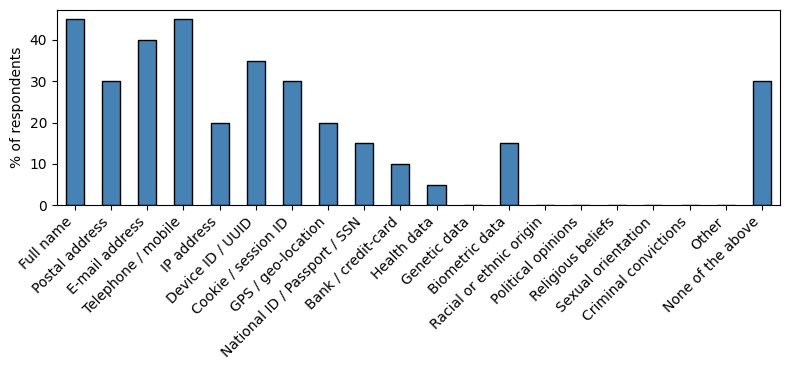


Percentage table:
 Full name                       45.0
Postal address                  30.0
E-mail address                  40.0
Telephone / mobile              45.0
IP address                      20.0
Device ID / UUID                35.0
Cookie / session ID             30.0
GPS / geo-location              20.0
National ID / Passport / SSN    15.0
Bank / credit-card              10.0
Health data                      5.0
Genetic data                     0.0
Biometric data                  15.0
Racial or ethnic origin          0.0
Political opinions               0.0
Religious beliefs                0.0
Sexual orientation               0.0
Criminal convictions             0.0
Other                            0.0
None of the above               30.0


In [347]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
da_cols = [f"DA02_{i:02d}" for i in range(1, 21)]
labels  = [              # 1‒20 exactly as in the questionnaire
    "Full name", "Postal address", "E-mail address", "Telephone / mobile",
    "IP address", "Device ID / UUID", "Cookie / session ID",
    "GPS / geo-location", "National ID / Passport / SSN",
    "Bank / credit-card", "Health data", "Genetic data",
    "Biometric data", "Racial or ethnic origin",
    "Political opinions", "Religious beliefs",
    "Sexual orientation", "Criminal convictions",
    "Other", "None of the above"
]

yes_counts = df[da_cols].apply(
    lambda col: col.str.strip().str.lower().eq("checked").sum()
)

pct = (yes_counts / len(df) * 100).round(1)
pct.index = labels

plt.figure(figsize=(8,3.8))
pct.plot.bar(color="steelblue", edgecolor="black")
plt.ylabel("% of respondents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

print("\nPercentage table:\n", pct.to_string())

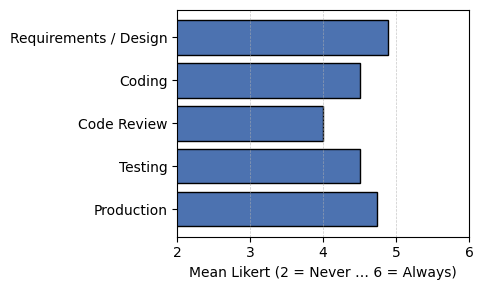

In [348]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
stage_labels = ["Requirements / Design", "Coding", "Code Review",
                "Testing", "Production"]
means = pi_numeric.mean().rename(dict(zip(pi_cols, stage_labels)))

plt.figure(figsize=(5,3))
plt.barh(stage_labels, means.values, color="#4c72b0", edgecolor="black")
plt.xlim(2,6)                                 # Likert range 2–6
plt.xlabel("Mean Likert (2 = Never … 6 = Always)")
plt.grid(axis='x', linestyle="--", linewidth=0.5, alpha=0.7)
plt.gca().invert_yaxis()                      # highest stage on top
plt.tight_layout(); plt.show()

/var/folders/gm/qkw22hmj6nb1q482lc1rgxqc0000gn/T/ipykernel_39506/502045124.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fam_num = df[lf_cols].replace(fam_map)


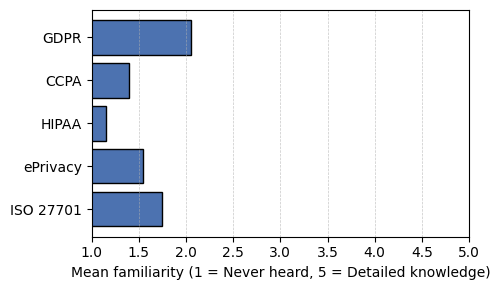

Familiarity means (1–5 scale):
GDPR         2.05
CCPA         1.40
HIPAA        1.15
ePrivacy     1.55
ISO 27701    1.75
dtype: float64


In [349]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
lf_cols = [f"LF01_0{i}" for i in range(1,6)]
reg_labels = ["GDPR","CCPA","HIPAA","ePrivacy","ISO 27701"]

scale = ["Never heard of", "Heard of", "Basic idea",
         "Good understanding", "Detailed knowledge"]
fam_map = {label: idx+1 for idx, label in enumerate(scale)}

fam_num = df[lf_cols].replace(fam_map)

means = fam_num.mean().rename(dict(zip(lf_cols, reg_labels)))

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.barh(reg_labels, means.values, color="#4c72b0", edgecolor="black")
plt.xlim(1,5)
plt.xlabel("Mean familiarity (1 = Never heard, 5 = Detailed knowledge)")
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

print("Familiarity means (1–5 scale):")
print(means.round(2))

/var/folders/gm/qkw22hmj6nb1q482lc1rgxqc0000gn/T/ipykernel_39506/1853555457.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fam_num = df[lf_cols + ["region_clean"]].replace(fam_map)


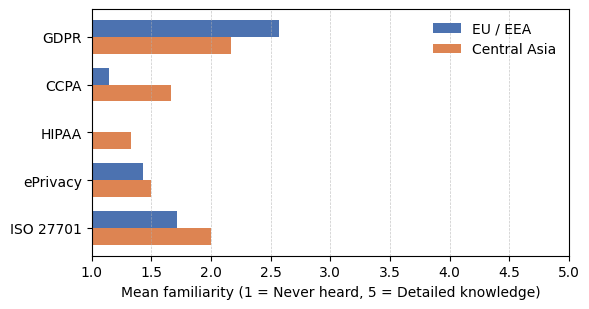

Mean familiarity by region:


,GDPR,CCPA,HIPAA,ePrivacy,ISO 27701
region_clean,,,,,
EU / EEA,2.57,1.14,1.00,1.43,1.71
Central Asia,2.17,1.67,1.33,1.50,2.00


In [350]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8", sep=",")
df["region_clean"] = df["DE04"].str.strip()

target_regions = ["EU / EEA", "Central Asia"]
fam_num = df[lf_cols + ["region_clean"]].replace(fam_map)
fam_reg = (fam_num
           .loc[df["region_clean"].isin(target_regions)]
           .groupby("region_clean")[lf_cols]
           .mean()
           .rename(columns=dict(zip(lf_cols, reg_labels)))
           .loc[target_regions])     

fam_reg_T = fam_reg.T

fig, ax = plt.subplots(figsize=(6,3.2))
y = np.arange(len(fam_reg_T.index))
bar_w = 0.35

ax.barh(y - bar_w/2, fam_reg_T["EU / EEA"], bar_w, label="EU / EEA",   color="#4c72b0")
ax.barh(y + bar_w/2, fam_reg_T["Central Asia"], bar_w, label="Central Asia", color="#dd8452")

ax.set_yticks(y); ax.set_yticklabels(fam_reg_T.index)
ax.set_xlabel("Mean familiarity (1 = Never heard, 5 = Detailed knowledge)")
ax.set_xlim(1,5); ax.invert_yaxis()
ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
ax.legend(frameon=False)
plt.tight_layout(); plt.show()

print("Mean familiarity by region:")
display(fam_reg.round(2))

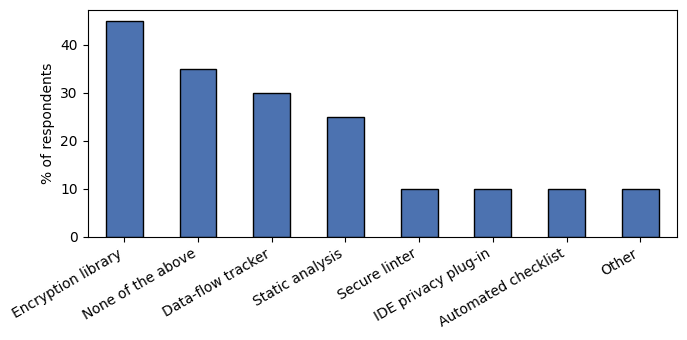


Tool-usage percentages:
Encryption library     45.0
None of the above      35.0
Data-flow tracker      30.0
Static analysis        25.0
Secure linter          10.0
IDE privacy plug-in    10.0
Automated checklist    10.0
Other                  10.0


In [351]:

tool_cols   = [f"OP03_0{i}" for i in range(1,7)] 
none_col    = "OP03_07"                          
other_text  = "OP03_06a"

tool_labels = ["Static analysis",        # OP03_01
               "Secure linter",          # OP03_02
               "IDE privacy plug-in",    # OP03_03
               "Data-flow tracker",      # OP03_04
               "Encryption library",     # OP03_05
               "Automated checklist"]    # OP03_06


is_checked = lambda s: s.str.lower().str.strip().eq("checked")

none_mask = is_checked(df[none_col])

tool_counts = {}
for col, label in zip(tool_cols, tool_labels):
    tool_counts[label] = (is_checked(df[col]) & ~none_mask).sum()

other_count = df.loc[(df[other_text].notna()) & (~none_mask), other_text].shape[0]

none_count = none_mask.sum()

counts = pd.Series(tool_counts)
counts["Other"]  = other_count
counts["None of the above"]  = none_count

pct = (counts / len(df) * 100).round(1).sort_values(ascending=False)


plt.figure(figsize=(7,3.5))
pct.plot.bar(color="#4c72b0", edgecolor="black")
plt.ylabel("% of respondents")
plt.xticks(rotation=30, ha="right")
plt.tight_layout(); plt.show()

print("\nTool-usage percentages:")
print(pct.to_string())

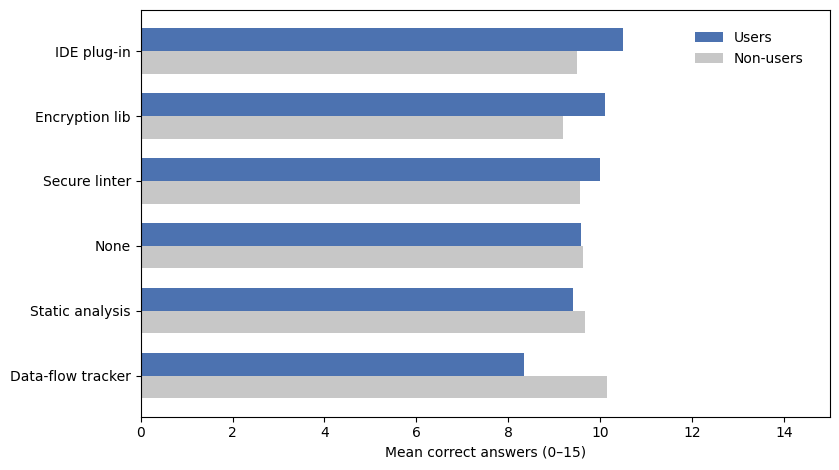

                Tool  n_yes  Mean_yes  Mean_no
2        IDE plug-in      2     10.50     9.50
4     Encryption lib      9     10.11     9.18
1      Secure linter      2     10.00     9.56
5               None      7      9.57     9.62
0    Static analysis      5      9.40     9.67
3  Data-flow tracker      6      8.33    10.14


In [352]:
df = pd.read_csv("survey_clean_columns_noZero.csv", encoding="utf-8")

tool_cols = {
    "OP03_01": "Static analysis",
    "OP03_02": "Secure linter",
    "OP03_03": "IDE plug-in",
    "OP03_04": "Data-flow tracker",
    "OP03_05": "Encryption lib",
    "OP03_06": "Checklist"
}

flags = {label: df[col].str.strip().eq("Checked") for col, label in tool_cols.items()}
flags["Other"] = df["OP03_06a"].notna() & ~df["OP03_07"].str.strip().eq("Checked")
flags["None"]  = df["OP03_07"].str.strip().eq("Checked")


tech_mask = np.zeros(len(df), dtype=bool)
for label in ["Static analysis","Secure linter","IDE plug-in",
              "Data-flow tracker","Encryption lib"]:
    tech_mask |= flags[label]

only_checklist = flags["Checklist"] & ~tech_mask & ~flags["Other"]
only_other     = flags["Other"]     & ~tech_mask & ~flags["Checklist"]
flags["None"] = flags["None"] | only_checklist | only_other
plot_flags = {k:v for k,v in flags.items() if k not in ["Checklist","Other"]}

rows=[]
for label,mask in plot_flags.items():
    yes,no = df.loc[mask,"snippet_score"], df.loc[~mask,"snippet_score"]
    if len(yes)>=2: 
        rows.append((label,len(yes),yes.mean(),no.mean()))
summary = pd.DataFrame(rows, columns=["Tool","n_yes","Mean_yes","Mean_no"])\
           .sort_values("Mean_yes", ascending=False)

plt.figure(figsize=(8.5,4.8))
y = np.arange(len(summary))
h = 0.35

plt.barh(y-h/2, summary["Mean_yes"], h, label="Users", color="#4c72b0")
plt.barh(y+h/2, summary["Mean_no"], h, label="Non-users", color="#c7c7c7")

plt.xlim(0, 15) 
plt.xlabel("Mean correct answers (0–15)")
plt.yticks(y, summary["Tool"])
plt.legend(
    loc="upper right",  
    bbox_to_anchor=(0.98, 0.98),
    frameon=False,
    ncol=1    
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(summary.round(2))